In [126]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from math import ceil, sqrt
import tensorflow as tf
from keras.models import load_model
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [1]:
model = load_model('./image_classification_bgg_as_it_is.h5')

In [2]:
# Open the HDF5 file
file = h5py.File(r"C:\Users\bg532fh\Documents\Personal\Kaggle\Vacation Destination\intel-image-classification\train_images.h5", "r+")
train_images = np.array(file["/images"]).astype("uint8")
train_labels = np.array(file["/meta"]).astype("uint8")
file = h5py.File(r"C:\Users\bg532fh\Documents\Personal\Kaggle\Vacation Destination\intel-image-classification\validation_images.h5", "r+")
validation_images = np.array(file["/images"]).astype("uint8")
validation_labels = np.array(file["/meta"]).astype("uint8")

In [127]:
from tf_cnnvis import *
np.random.seed(10)
import time, os,csv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
top_images_file = "top_9_images.csv"
top_images={}
f = open(top_images_file, "r")
w = csv.reader(f)
for row in w:
    if len(row)>1:
        key,val = row
        top_images[key] = val
f.close()

In [10]:
g = K.get_session().graph
names = [op.name for op in K.get_session().graph.get_operations()]
input_tensor = g.get_tensor_by_name(names[0] + ':0')

In [12]:
K.get_session()

In [2]:
import re
# api call
layers = ['block1_pool/MaxPool:3','block2_pool/MaxPool:6','block3_pool/MaxPool:10','block4_pool/MaxPool:14']
for layer in layers:
    layer_name,layer_number = layer.split(":") 
    filters = int(g.get_tensor_by_name(layer_name +":0").shape[-1])
    for _filter in range(filters):
        index_str = top_images[str(layer_number)+"_"+str(_filter+1)][1:-1]
        index_str = re.sub("\s+"," ",index_str).strip()
        feed_images = np.array([train_images[int(index)] for index in index_str.split(' ')])
        feed_dict = {input_tensor:feed_images}
        deconv_visualization_one_layer(sess_graph_path = K.get_session(), value_feed_dict = feed_dict, 
                                          input_tensor=input_tensor, layers=layer_name, filters=_filter,
                                          path_logdir=os.path.join("Log","MNISTExample"), 
                                          path_outdir=os.path.join("Output","MNISTExample"))

In [131]:
import re
# convert a array of images or list of arrays of images into grid images
def convert_into_grid(Xs, ubound=255.0, padding=1):
    """
    Convert 4-D numpy array into a grid image

    :param Xs:
        A numpy array of images to make grid out of it
    :type Xs: 4-D numpy array (first axis contations an image)

    :param ubound:
        upperbound for a image pixel value
    :type ubound: float (Default = 255.0)

    :param padding:
        padding size between grid cells
    :type padding: int (Default = 1)

    :return:
        A grid of input images
    :rtype: 3-D numpy array
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid.astype('uint8')


In [132]:
from imageio import imread
filter_images = {}
layers = ['block3_pool/MaxPool:3','block4_pool/MaxPool:6']
for layer in layers:
    layer_name,layer_number = layer.split(":") 
    filters = int(g.get_tensor_by_name(layer_name +":0").shape[-1])
    filter_images[str(layer_name)] = []
    for _filter in range(filters):
        path_outdir=os.path.join("Output","MNISTExample")
        path_out =  os.path.join(path_outdir,layer_name.replace('/','_'))
        grid_image_path = os.path.join(path_out, "deconvolution_"+str(_filter))
        filter_images[str(layer_name)].append(imread(os.path.join(grid_image_path, "grid_image.png"),format='png'))        

In [133]:
# convert a array of images or list of arrays of images into grid images
def convert_into_grid(Xs, ubound=255.0, padding=1):
    """
    Convert 4-D numpy array into a grid image

    :param Xs:
        A numpy array of images to make grid out of it
    :type Xs: 4-D numpy array (first axis contations an image)

    :param ubound:
        upperbound for a image pixel value
    :type ubound: float (Default = 255.0)

    :param padding:
        padding size between grid cells
    :type padding: int (Default = 1)

    :return:
        A grid of input images
    :rtype: 3-D numpy array
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid.astype('uint8')

In [134]:
from imageio import imsave
layers = ['block3_pool/MaxPool:3','block4_pool/MaxPool:6']
for layer in layers:
    layer_name,layer_number = layer.split(":") 
    Xs = np.array(filter_images[layer_name])
    grid_Xs = convert_into_grid(Xs)
    path_out =  os.path.join(path_outdir, layer_name.replace('/','_'))
    imsave(os.path.join(path_out, "complete_layer_grid.png"), grid_Xs, format = "png")

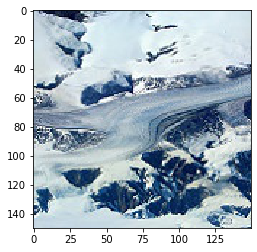

In [136]:
plt.imshow(train_images[6328])